In [1]:
#import pandas as pd
#from sodapy import Socrata

#client = Socrata("www.datos.gov.co", None)

#df_2020_2 = pd.DataFrame(client.get("rnvb-vnyh", limit=504872, offset=0))

#df_2020_1 = pd.DataFrame(client.get("a8xr-en99", limit=15435, offset=0))

In [34]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from dython import nominal
import matplotlib.pyplot as plt

In [3]:
# define functions
def lower_names(df):
    l_names = {col: col.lower() for col in df.columns}
    return df.rename(l_names)

def plot_null_vals(df):
    null_bool = df.select([pl.col(col).is_null() for col in df.columns])
    
    null_array = null_bool.to_numpy().astype(int).T
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.imshow(null_array, aspect='auto', cmap='viridis', interpolation='none')
    
    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)
    ax.set_xticks([])
    plt.title('Valores nulos por columna')
    
    return plt.show()

def data_type(df):
    df_type = pl.DataFrame(
        {
            "col_name": df.columns,
            "var_type": [df_h[col].dtype for col in df.columns]
        }
    )

    return df_type

def impute_mode(df):
    
    for col in df.columns:
        n_row = df.shape[0]   
        mode_col = df[col].drop_nulls().mode().item()
        
        if df[col].null_count() > 0:
            df = df.with_columns(
                pl.col(col).fill_null(mode_col))
    return df

In [4]:
# load data
df_h = pl.read_csv("/Users/sebas/OneDrive/Documents/repositorio_cepap/CEPAP/data_source/educacion/2025/Resultados__nicos_Saber_11_20250303.tsv", separator="\t", decimal_comma = True)

df_h.head()

PERIODO,ESTU_TIPODOCUMENTO,ESTU_CONSECUTIVO,COLE_AREA_UBICACION,COLE_BILINGUE,COLE_CALENDARIO,COLE_CARACTER,COLE_COD_DANE_ESTABLECIMIENTO,COLE_COD_DANE_SEDE,COLE_COD_DEPTO_UBICACION,COLE_COD_MCPIO_UBICACION,COLE_CODIGO_ICFES,COLE_DEPTO_UBICACION,COLE_GENERO,COLE_JORNADA,COLE_MCPIO_UBICACION,COLE_NATURALEZA,COLE_NOMBRE_ESTABLECIMIENTO,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,ESTU_COD_DEPTO_PRESENTACION,ESTU_COD_MCPIO_PRESENTACION,ESTU_COD_RESIDE_DEPTO,ESTU_COD_RESIDE_MCPIO,ESTU_DEPTO_PRESENTACION,ESTU_DEPTO_RESIDE,ESTU_ESTADOINVESTIGACION,ESTU_ESTUDIANTE,ESTU_FECHANACIMIENTO,ESTU_GENERO,ESTU_MCPIO_PRESENTACION,ESTU_MCPIO_RESIDE,ESTU_NACIONALIDAD,ESTU_PAIS_RESIDE,ESTU_PRIVADO_LIBERTAD,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONMADRE,FAMI_EDUCACIONPADRE,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_TIENEAUTOMOVIL,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,DESEMP_INGLES,PUNT_INGLES,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_LECTURA_CRITICA,PUNT_GLOBAL
i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64
20131,"""CR""","""SB11201310000414""","""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N""","""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si""","""B+""","""94""","""88""",null,null,null,null
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20122,"""TI""","""SB11201220204399""","""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No""","""A1""","""48""","""45""",null,null,null,null
20132,"""TI""","""SB11201320464198""","""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N""","""Cinco""","""Educación profesional completa""","

In [5]:
# dimensiones
print("las dimensiones de la tabla original correponden a " + str(df_h.shape[0]) + " filas y " + str(df_h.shape[1]) + " columnas.")

las dimensiones de la tabla original correponden a 7109704 filas y 51 columnas.


In [6]:
# clean names
df_h = lower_names(df_h)

df_h.head()

periodo,estu_tipodocumento,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64
20131,"""CR""","""SB11201310000414""","""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N""","""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si""","""B+""","""94""","""88""",null,null,null,null
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20122,"""TI""","""SB11201220204399""","""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No""","""A1""","""48""","""45""",null,null,null,null
20132,"""TI""","""SB11201320464198""","""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N""","""Cinco""","""Educación profesional completa""","

In [7]:
# Explorar variables por prefijos
prefjs = ["cole", "estu_", "fami_", "punt_"]

In [8]:
# Columnas colegio
columnas_cole = [col for col in df_h.columns if col.startswith(prefjs[0])]
df_h.select(columnas_cole).head()

cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal
str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str
"""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S"""
"""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N"""
"""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N"""
"""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S"""
"""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S"""


In [9]:
# Columnas estudiante
columnas_estu = [col for col in df_h.columns if col.startswith(prefjs[1])]
df_h.select(columnas_estu).head()

estu_tipodocumento,estu_consecutivo,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad
str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str
"""CR""","""SB11201310000414""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201940464873""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201940464873""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201220204399""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201320464198""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N"""


In [10]:
# Columnas familia
columnas_fami = [col for col in df_h.columns if col.startswith(prefjs[2])]
df_h.select(columnas_fami).head()

fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora
str,str,str,str,str,str,str,str,str
"""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si"""
"""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si"""
"""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si"""
"""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No"""
"""Cinco""","""Educación profesional completa""","""Educación profesional incomple…","""Estrato 2""","""Ocho""","""No""","""Si""","""Si""","""Si"""


In [11]:
# Columnas puntaje
columnas_punt = [col for col in df_h.columns if col.startswith(prefjs[3])]
df_h.select(columnas_punt).head()

punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
str,str,i64,i64,i64,i64
"""94""","""88""",null,null,null,null
"""71""","""66""",70,65,69,339
"""71""","""66""",70,65,69,339
"""48""","""45""",null,null,null,null
"""43""","""52""",null,null,null,null


In [12]:
# Conteo observaciones por periodo
df_h.group_by("periodo").len()

periodo,len
i64,u32
20142,546727
20121,38432
20191,12561
20161,13095
20224,1065888
…,…
20112,617442
20131,35179
20151,25973


In [13]:
# filter periods
df_h = df_h.filter(df_h["periodo"].is_in([20171, 20172, 20191, 20194]))

df_h.shape

(1670372, 51)

In [14]:
# sample 500.000 records
df_h = df_h.sample(n = 500000, seed = 2025)

In [15]:
#clean data type
df_h = df_h.with_columns(
    pl.col("punt_matematicas").cast(pl.Float64),
    pl.col("punt_ingles").cast(pl.Float64)
)

In [16]:
# print data type
data_type(df_h)

col_name,var_type
str,object
"""periodo""",Int64
"""estu_tipodocumento""",String
"""estu_consecutivo""",String
"""cole_area_ubicacion""",String
"""cole_bilingue""",String
…,…
"""punt_matematicas""",Float64
"""punt_sociales_ciudadanas""",Int64
"""punt_c_naturales""",Int64


In [17]:
cols_punt = [col for col in df_h.columns if col.startswith("punt_")]

df_h.select(cols_punt).describe()

statistic,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
str,f64,f64,f64,f64,f64,f64
"""count""",499988.0,500000.0,500000.0,500000.0,500000.0,500000.0
"""null_count""",12.0,0.0,0.0,0.0,0.0,0.0
"""mean""",49.09884,50.608844,47.75663,49.40955,52.659148,250.154332
"""std""",12.55179,12.11872,12.086802,10.745406,10.375504,51.290681
"""min""",0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",40.0,42.0,38.0,41.0,45.0,211.0
"""50%""",48.0,51.0,47.0,49.0,53.0,247.0
"""75%""",57.0,59.0,57.0,57.0,60.0,286.0
"""max""",100.0,100.0,100.0,100.0,100.0,476.0


In [18]:
# Arbitrary select vars
df_h = df_h.select(["estu_genero", "cole_calendario", "fami_educacionmadre", "fami_educacionpadre",
                    "fami_estratovivienda", "fami_tienecomputador", "cole_area_ubicacion", "fami_tieneinternet", "punt_global"])

In [19]:
# Conteo de la cantidad de valores perdidos y su proporción por columna
pl.DataFrame(
    {
        "col_name": df_h.columns,
        "missing_values": [df_h[col].null_count() for col in df_h.columns],
        "propotion_missing_values": [round((df_h[col].null_count() / df_h.shape[0]), 3) * 100 for col in df_h.columns]
    }
) \
.sort("missing_values", descending = True)

col_name,missing_values,propotion_missing_values
str,i64,f64
"""fami_estratovivienda""",29308,5.9
"""fami_tieneinternet""",26468,5.3
"""fami_educacionpadre""",25887,5.2
"""fami_educacionmadre""",25831,5.2
"""fami_tienecomputador""",13156,2.6
"""estu_genero""",78,0.0
"""cole_calendario""",0,0.0
"""cole_area_ubicacion""",0,0.0
"""punt_global""",0,0.0


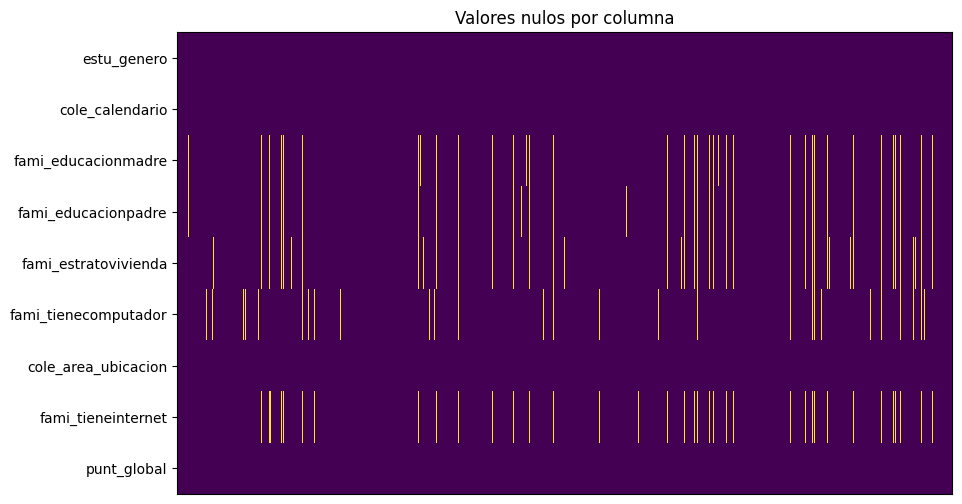

In [20]:
plot_null_vals(df_h)

In [21]:
# imputar datos faltantes con la moda
df_h = impute_mode(df_h)

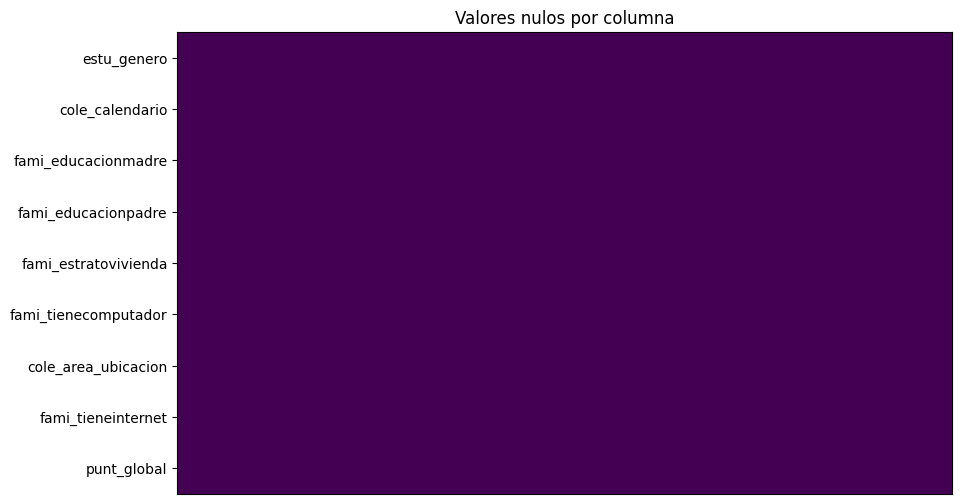

In [22]:
# verfy delete null values
plot_null_vals(df_h)

In [23]:
print("Luego de la selección arbitraria de variables, se observa un total de " + str(df_h.shape[0]) +
      " filas y " + str(df_h.shape[1]) + " columnas")

Luego de la selección arbitraria de variables, se observa un total de 500000 filas y 9 columnas


In [24]:
# print data type
data_type(df_h)

col_name,var_type
str,object
"""estu_genero""",String
"""cole_calendario""",String
"""fami_educacionmadre""",String
"""fami_educacionpadre""",String
"""fami_estratovivienda""",String
"""fami_tienecomputador""",String
"""cole_area_ubicacion""",String
"""fami_tieneinternet""",String
"""punt_global""",Int64


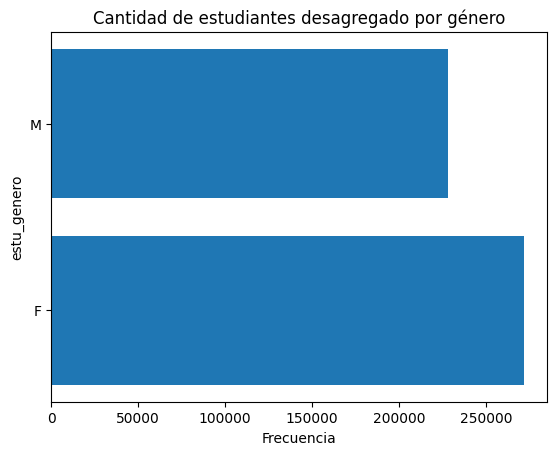

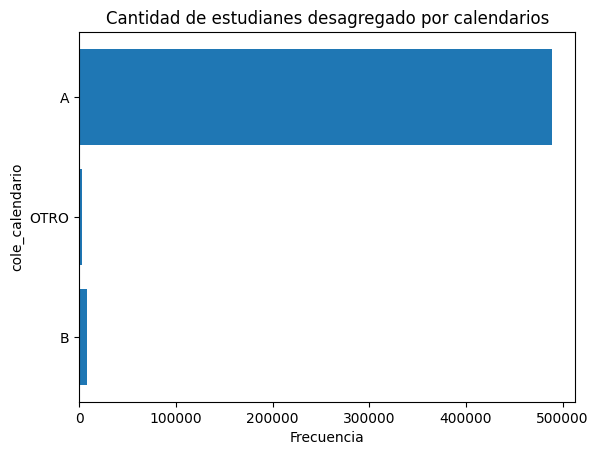

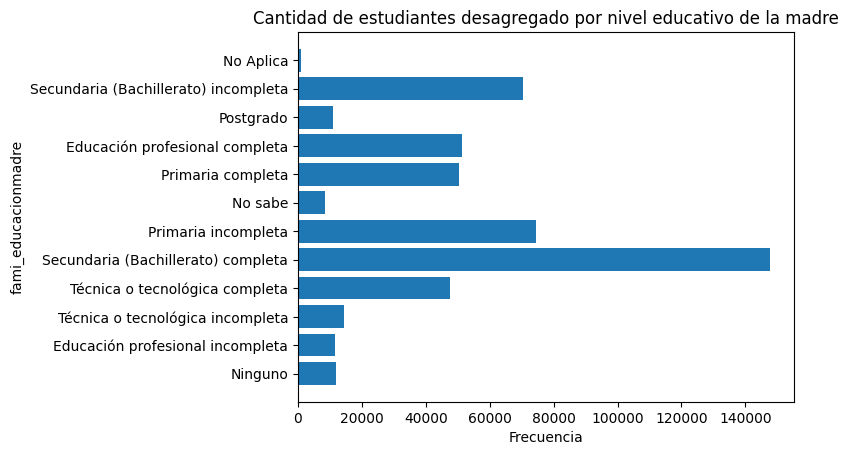

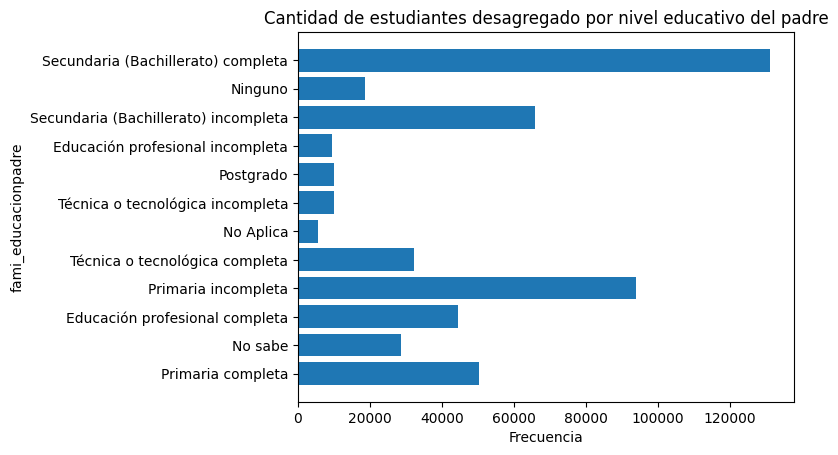

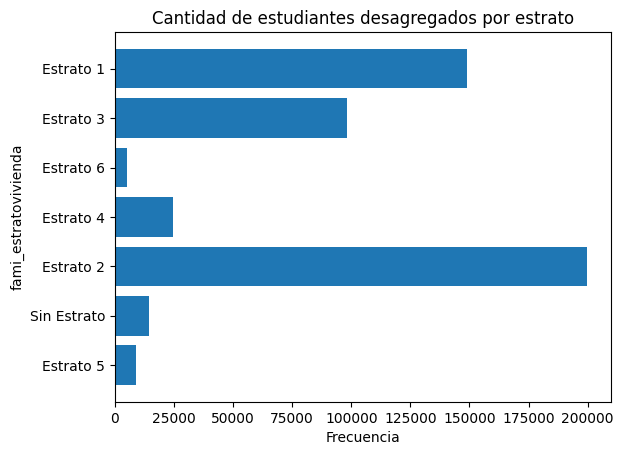

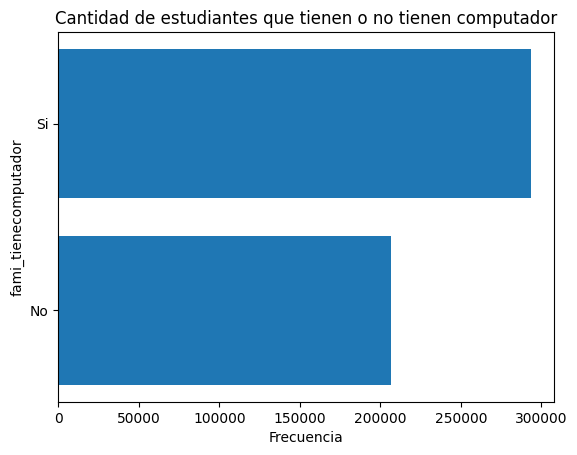

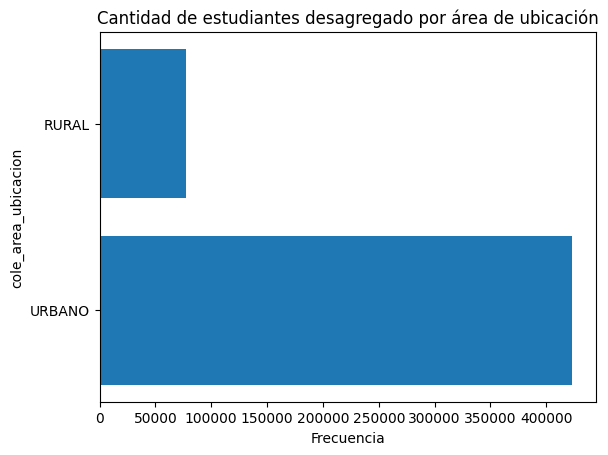

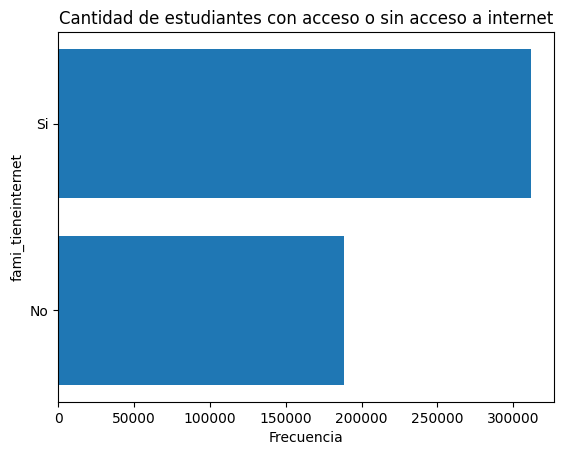

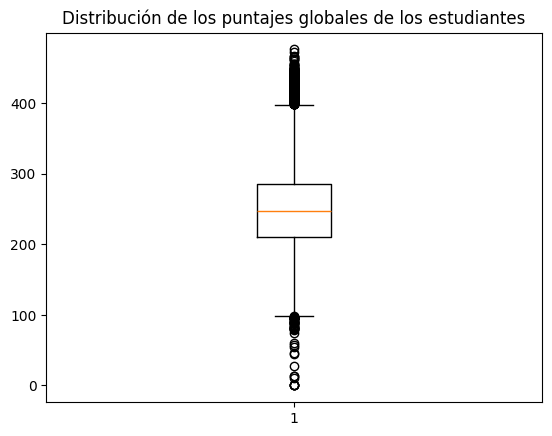

In [25]:
# plot count unique values
var_names_plot = df_h.columns

var_names_plot.remove("punt_global")

titles_plots = ["Cantidad de estudiantes desagregado por género", "Cantidad de estudianes desagregado por calendarios",
                "Cantidad de estudiantes desagregado por nivel educativo de la madre",
                "Cantidad de estudiantes desagregado por nivel educativo del padre",
                "Cantidad de estudiantes desagregados por estrato", "Cantidad de estudiantes que tienen o no tienen computador",
                "Cantidad de estudiantes desagregado por área de ubicación",
                "Cantidad de estudiantes con acceso o sin acceso a internet"]

for i in range(0, len(var_names_plot)):
    count_val = df_h[var_names_plot[i]].value_counts()

    plt.barh(count_val[var_names_plot[i]], count_val["count"])
    plt.xlabel("Frecuencia")
    plt.ylabel(var_names_plot[i])
    plt.title(titles_plots[i])
    plt.show()

plt.boxplot(df_h["punt_global"])
plt.title("Distribución de los puntajes globales de los estudiantes")
plt.show()


In [26]:
# Cantidad valores únicos para las variables categóricas de la educación de los padres
print("La variable que da cuenta del nivel de educación de la madre posee " + str(len(df_h["fami_educacionmadre"].unique())) +
      " valores únicos")
print("La variable que da cuenta del nivel de educación del padre posee " + str(len(df_h["fami_educacionpadre"].unique())) +
      " valores únicos")

La variable que da cuenta del nivel de educación de la madre posee 12 valores únicos
La variable que da cuenta del nivel de educación del padre posee 12 valores únicos


In [27]:
# Conteo de la cantidad de valores únicos por columna
pl.DataFrame(
    {
        "col_name": df_h.columns,
        "n_unique_values": [len(df_h[col].unique()) for col in df_h.columns]
    }
).sort("n_unique_values", descending = True)

col_name,n_unique_values
str,i64
"""punt_global""",388
"""fami_educacionmadre""",12
"""fami_educacionpadre""",12
"""fami_estratovivienda""",7
"""cole_calendario""",3
"""estu_genero""",2
"""fami_tienecomputador""",2
"""cole_area_ubicacion""",2
"""fami_tieneinternet""",2


In [28]:
homolgr_vals = {
    "Educación profesional completa" : "Pregrado",
    "Educación profesional incompleta" : "Bachillerato",
    "No Aplica" : "NS",
    "No sabe" : "NS",
    "Técnica o tecnológica completa" : "Tecnica",
    "Técnica o tecnológica incompleta": "Bachillerato",
    "Secundaria (Bachillerato) incompleta" : "Primaria",
    "Secundaria (Bachillerato) completa" : "Bachillerato",
    "Primaria completa" : "Primaria",
    "Primaria incompleta" : "Ninguno",
    "Postgrado" : "Postgrado",
    "Ninguno" : "Ninguno"
}

df_h = df_h.with_columns(
    pl.col("fami_educacionmadre").replace(homolgr_vals).alias("fami_educacionmadre"),
    pl.col("fami_educacionpadre").replace(homolgr_vals).alias("fami_educacionpadre"))

In [29]:
# Conteo de la cantidad de valores perdidos y su proporción por columna
pl.DataFrame(
    {
        "col_name": df_h.columns,
        "n_unique_values": [len(df_h[col].unique()) for col in df_h.columns]
    }
).sort("n_unique_values", descending = True)

col_name,n_unique_values
str,i64
"""punt_global""",388
"""fami_educacionmadre""",7
"""fami_educacionpadre""",7
"""fami_estratovivienda""",7
"""cole_calendario""",3
"""estu_genero""",2
"""fami_tienecomputador""",2
"""cole_area_ubicacion""",2
"""fami_tieneinternet""",2


## Fase 2

In [30]:
df_p = df_h.to_pandas()

print(type(df_p))

<class 'pandas.core.frame.DataFrame'>


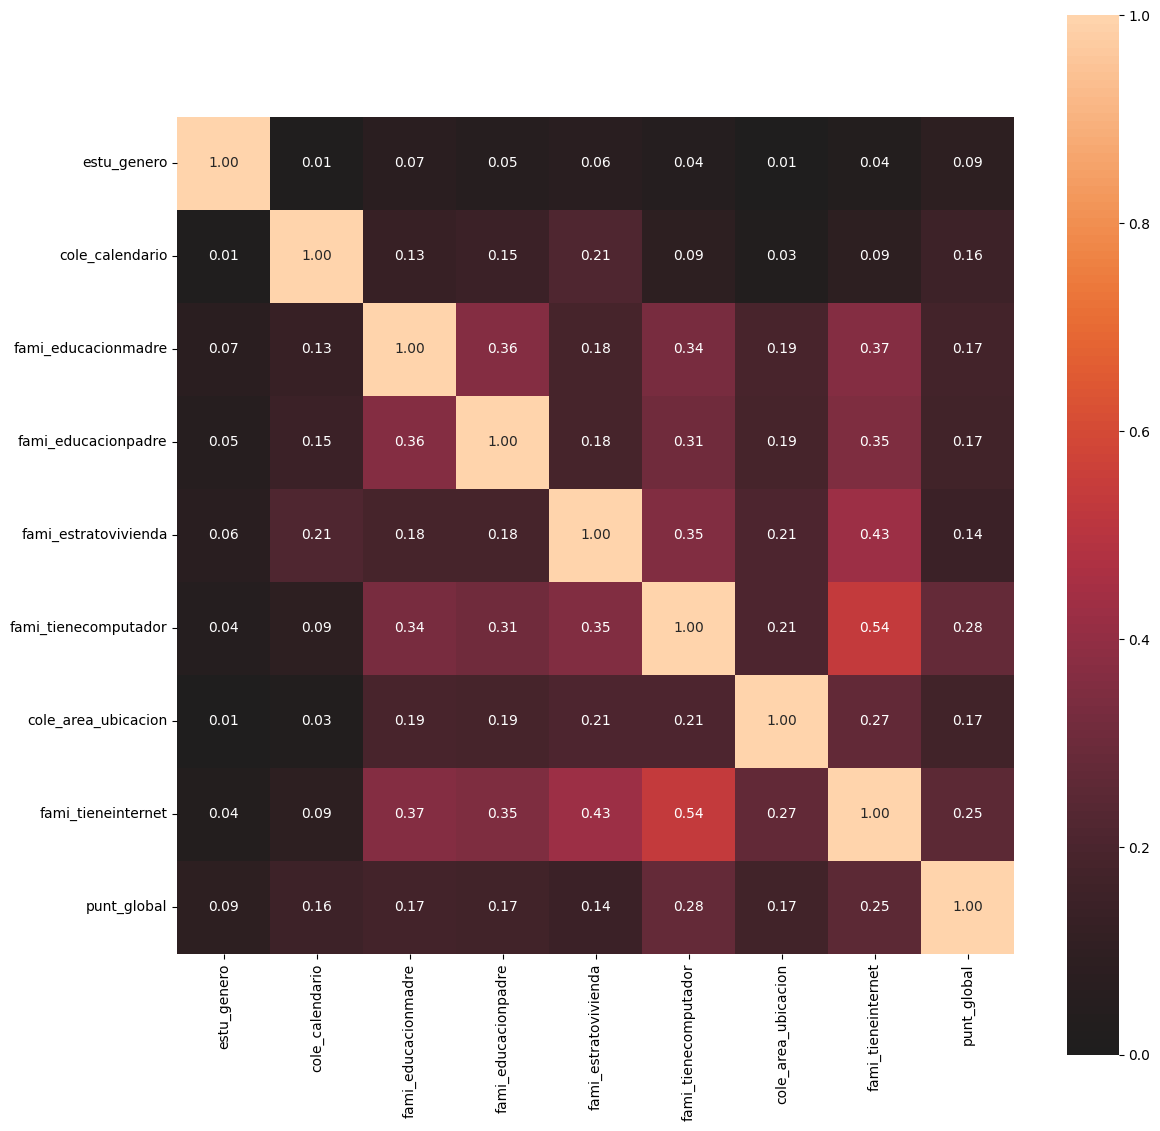

In [32]:
cramers_v_value = nominal.associations(
    df_p, nominal_columns=['fami_educacionmadre', 'fami_educacionpadre'],
    numerical_columns=[])['corr']['fami_educacionmadre']['fami_educacionpadre']

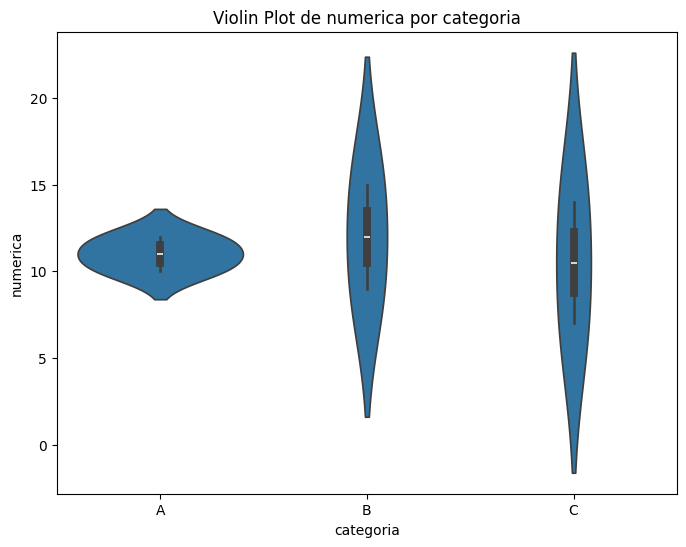

In [39]:
def violinplot_polars(df, variable_numerica, variable_categorica):
    """
    Genera un violin plot para visualizar la relación entre una variable numérica y una categórica.

    Args:
        df: DataFrame de Polars.
        variable_numerica: Nombre de la columna numérica.
        variable_categorica: Nombre de la columna categórica.
    """
    df_pd = df.to_pandas()  # Convertir a Pandas para Seaborn
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=variable_categorica, y=variable_numerica, data=df_pd)
    plt.title(f'Violin Plot de {variable_numerica} por {variable_categorica}')
    plt.xlabel(variable_categorica)
    plt.ylabel(variable_numerica)
    plt.show()

# Ejemplo de uso
# Crear un DataFrame de ejemplo
data = {'categoria': ['A', 'B', 'C', 'A', 'B', 'C', 'A'],
        'numerica': [10, 15, 7, 12, 9, 14, 11]}
df = pl.DataFrame(data)
violinplot_polars(df, 'numerica', 'categoria')